<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/07-autoencoding-and-self-supervision/02_denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Denoising Autoencoder

In this notebook, we shows that bread-and-butter
principal component analysis (PCA) works by secretly being an autoencoder.

We’ll make small changes to a PyTorch version of PCA to change it into a fully fledged
autoencoding neural network. 

As we make an autoencoding network larger, it becomes
more important to constrain it well, which we demonstrate with the denoising strategy.

Finally we apply these concepts to sequential models like RNNs, which gives the autoregressive model.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, View, weight_reset, set_seed

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
def show_encoded_decoded_image(encode_decode, x):
  """
  encode_decode: the PyTorch Module that does the encoding and decoding steps at once
  x: the input to plot as is, and after encoding & decoding it
  """
  #Switch to eval mode
  encode_decode = encode_decode.eval()
  #We will move things to the CPU so that we don't have to think about what device anything was on
  #and because this functino is not performance sensative
  encode_decode = encode_decode.cpu()
  with torch.no_grad():#Always no_grad if you are not training
      x_recon = encode_decode(x.cpu())
  #Use matplotlib to create a size-by-side plot with the original on the left
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(x.numpy()[0,:])
  axarr[1].imshow(x_recon.numpy()[0,0,:])

##Dataset

Now we want to create a wrapper for the MNIST datasets. 

Why? Because the default MNIST dataset will return data in pairs `(x, y)` for the input and label, respectively. 

But in our case, the input is the label because we are trying to predict the output from the input.

So we extend the PyTorch Dataset class to take the original tuple `x, y` and instead return a tuple `x, x`.

In [7]:
class AutoEncoderDataset(Dataset):
  """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs."""
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset.__getitem__(idx)
    # just throw away the original label.
    return x, x

In [ ]:
B = 128

train_data = AutoEncoderDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncoderDataset(test_data_xy)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data_xx, batch_size=B)

##Denoising

A denoising autoencoder adds noise to the encoder’s input while still expecting the
decoder to produce a clean image.

If we
do this, there is no naive solution of just copying the input, because we perturb it before
giving it to the network. The network must learn how to remove the noise, or denoise,
the input and thus allows us to use $\hat D > D$ while still obtaining robust representations.

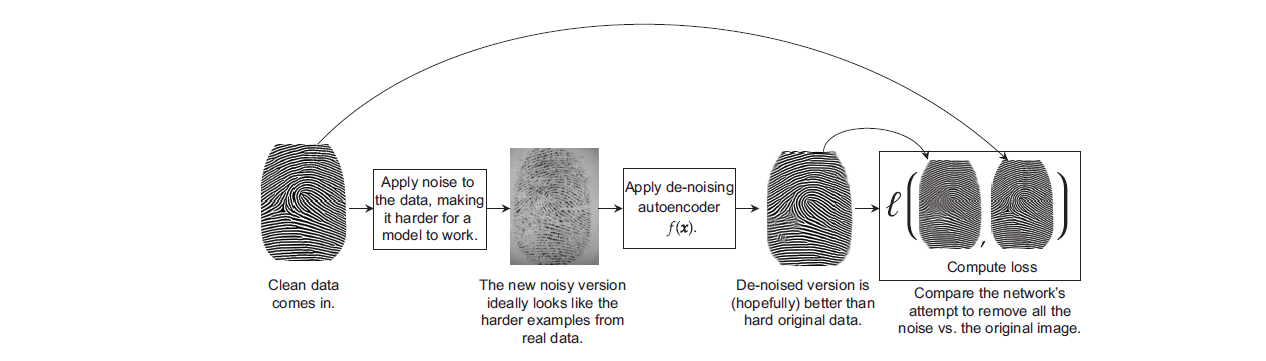

##Denoising with Gaussian noise

We will add a
new layer at the beginning of the encoder subnetwork, which adds noise to the input
only when we are training. 

The assumption is usually that our training data is relatively
clean and prepared, and we are adding noise to make it more robust. If we are then
using the model, and no longer training, we want to get the best answer we can—which
means we want the cleanest data possible. 

Adding noise at that stage would make our
lives more difficult, and if the input already had noise, we would just compound the
problem.

Let’s define some basic hyperparameters.

In [9]:
D = 28 * 28       # input size
n = 2             # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

In [10]:
# first argument is the mean, second is the standard deviation 
normal = torch.distributions.Normal(0, 0.5)

In [11]:
# creating our noisy sample
def add_noise(x, device="cpu"):
  return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

In [12]:
def get_layer(in_size, out_size):
  """
  in_size: how many neurons/features are coming into this layer
  out_size: how many neurons/outputs this hidden layer should produce
  """
  return nn.Sequential( #Organize the conceptual "block" of a hidden layer into a Sequential object
      nn.Linear(in_size,  out_size),
      nn.BatchNorm1d(out_size),
      nn.ReLU())

Let's define a new `AdditiveGaussNoise` layer. It takes the input x
in. 

If we are in training mode (denoted by `self.training`), we add noise to the input;
otherwise we return it unperturbed.

In [13]:
class AdditiveGausNoiseLayer(nn.Module):
  def __init__(self):
    super().__init__()
    # We don't need to do anything in the constructor of this object.

  def forward(self, x):
    # check if we are in training (True) or evaluation (False) mode.
    if self.training:
      return add_noise(x, device=device)
    else:  # Now training, return the data as it was given
      return x

Next, we define the large autoencoder, where $\hat D = 2 * D$. 

The only
difference is that we insert the `AdditiveGaussNoise` layer at the start of the network.

In [14]:
denoising_auto_encoder = nn.Sequential(
  nn.Flatten(),
  # Only addition! Inserting noise here hopefully helps
  AdditiveGausNoiseLayer(),
  get_layer(D, D * 2),
  get_layer(D * 2, D * 2),
  get_layer(D * 2, D * 2),
  nn.Linear(D * 2, D * 2)
)

denoising_auto_decoder = nn.Sequential(
  get_layer(D * 2, D * 2),
  get_layer(D * 2, D * 2),
  get_layer(D * 2, D * 2),
  get_layer(D * 2, D),
  # Reshape to match the original shape
  View(-1, 1, 28, 28)
)

# Combine into a deep auto encoder
denoising_auto_encoder_decoder = nn.Sequential(
  denoising_auto_encoder,
  denoising_auto_decoder
) 

In [15]:
mse_loss = nn.MSELoss() #Original loss function
# Let's train this model
train_network(denoising_auto_encoder_decoder, mse_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,20.680955,0.046884,0.022972
1,1,34.660737,0.025311,0.018627
2,2,49.938544,0.021582,0.014690
3,3,61.888871,0.019618,0.014069
4,4,73.898108,0.017955,0.012220
5,5,85.552415,0.017117,0.011729
6,6,102.138482,0.016491,0.010886
7,7,115.780115,0.015592,0.010463
8,8,127.460027,0.015158,0.010156
9,9,139.126913,0.014730,0.009738


The new denoising model is clearly the best at creating reconstructions
of all the models we have developed so far. In both cases, the denoising autoencoder
captures most of the style of the individual digits. 

The denoising approach still misses
small details, likely because they are so small that the model isn’t sure if they are a real
part of the style or part of the noise. 

For example, the flourishes on the bottom of the 4
and the top of the 5 are missing after reconstruction

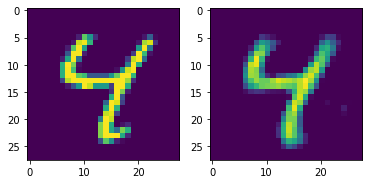

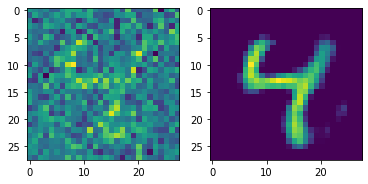

In [16]:
# Showing the input (left) and output (right) for three data points
show_encoded_decoded_image(denoising_auto_encoder_decoder, test_data_xy[6][0])
show_encoded_decoded_image(denoising_auto_encoder_decoder, add_noise(test_data_xy[6][0]))

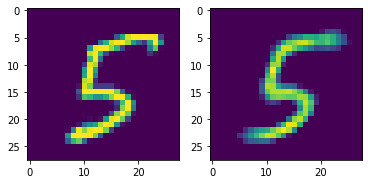

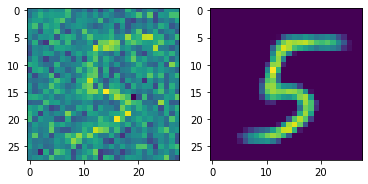

In [17]:
show_encoded_decoded_image(denoising_auto_encoder_decoder, test_data_xy[23][0])
show_encoded_decoded_image(denoising_auto_encoder_decoder, add_noise(test_data_xy[23][0]))

The denoising approach is very popular for training autoencoders, and the trick of
introducing your own perturbations into the data is widely used to build more accurate
and robust models.

Beyond helping learn more robust representations, the denoising approach can itself be a useful model. Noise can naturally occur in many situations. 

For example, when
performing optical character recognition (OCR) to convert an image into searchable
text, you can get noise from damage to the camera, damage to the document (e.g.,
water or coffee stains), changes in lighting, objects casting shadows, and so on. 

Many OCR systems have been improved by learning to add noise that looks like the noise
seen in real life and asking the model to learn in spite of it.

## Denoising with Dropout

Adding Gaussian noise can be cumbersome because we need to figure out exactly how much noise to add, which can change from dataset to dataset. 

A second, more popular
approach is to use dropout.

Let's trains up a dropout-based denoising autoencoder. 

By default, dropout uses `p = 50%`, which is fine for hidden layers but on the aggressive size
for the input. 

So for the input, we apply only `p = 20%`:

In [18]:
denoising_auto_encoder_dropout = nn.Sequential(
  nn.Flatten(),
  nn.Dropout(p=.2),   # For the input we will usually drop only 5-20% of the values
  get_layer(D, D * 2),
  nn.Dropout(),       # By defult dropout uses 50% probability to zero-out values
  get_layer(D * 2, D * 2),
  nn.Dropout(),
  get_layer(D * 2, D * 2),
  nn.Dropout(),
  nn.Linear(D * 2, D * 2)
)

denoising_auto_decoder_dropout = nn.Sequential(
  get_layer(D * 2, D * 2),
  nn.Dropout(),
  get_layer(D * 2, D * 2),
  nn.Dropout(),
  get_layer(D * 2, D * 2),
  nn.Dropout(),
  nn.Linear(D * 2, D),
  # Reshape to match the original shape
  View(-1, 1, 28, 28)
)

# Combine into a deep auto encoder
denoising_auto_encoder_decoder_dropout = nn.Sequential(
  denoising_auto_encoder_dropout,
  denoising_auto_decoder_dropout
) 

In [19]:
# Let's train this model
train_network(denoising_auto_encoder_decoder_dropout, mse_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,11.233521,0.062739,0.034105
1,1,22.349803,0.037654,0.029107
2,2,34.904942,0.033680,0.024571
3,3,46.350844,0.031299,0.022354
4,4,57.456210,0.029953,0.021400
5,5,69.944600,0.028862,0.021218
6,6,81.797653,0.028167,0.019697
7,7,94.944355,0.027713,0.019185
8,8,108.796797,0.027410,0.018759
9,9,120.556274,0.026796,0.018312


Now that the model is trained, let’s apply it to some of the test data. 
Dropout can
encourage a large degree of robustness, which we can show off by applying it to both
dropout noise and Gaussian noise.

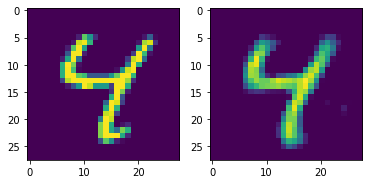

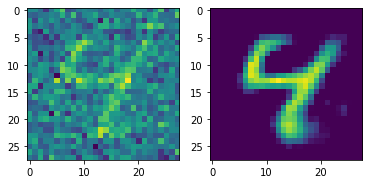

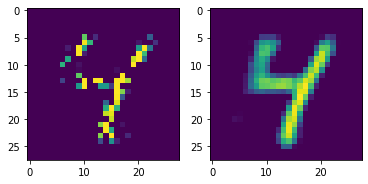

In [20]:
# Clean data
show_encoded_decoded_image(denoising_auto_encoder_decoder, test_data_xy[6][0])
# guassian noise
show_encoded_decoded_image(denoising_auto_encoder_decoder, add_noise(test_data_xy[6][0]))
# dropout noise
show_encoded_decoded_image(denoising_auto_encoder_decoder, nn.Dropout()(test_data_xy[6][0]))

The last one is something the network has never seen
before, but that does not stop the autoencoder from faithfully determining an accurate
reconstruction.